In [1]:
import spot
spot.setup()

This notebook demonstrates the implementation of Zielonka Tree and ACD (Alternating Cycle Decomposition)
in Spot.  

These two structures are used to decompose an acceptance condition (or automaton) into trees that alternate accepting and rejecting elements in order to help converting an automaton to parity acceptance.  Spot implements those structures, includes some display code to better explore them iteractively, and finally use them to implement a transformation to parity acceptance.

For a formal treatment of these, in a slightly different formalism, see [Optimal Transformations of Games and Automata Using Muller Conditions](https://arxiv.org/abs/2011.13041) by Casares, Colcombet, and Fijalkow.  In Spot those definitions have been adapted to use Emerson-Lei acceptance, and support transitions labeled by multiple colors (the main differences are for the Zielonka Tree, the ACD is almost identical).

# Zielonka Tree

The Zielonka tree is built from an acceptance formula and is labeled by sets of colors.  The root contains all colors used in the formula.  If seeing infinitely all colors of one node would satisfy the acceptance condition, we say that the node is accepting and draw it with an ellipse, otherwise is is rejecting and drawn with a rectangle.  The children of an accepting (resp. rejecting) node, are the largest subsets of colors that are rejecting (resp. accepting).

Here is an example:

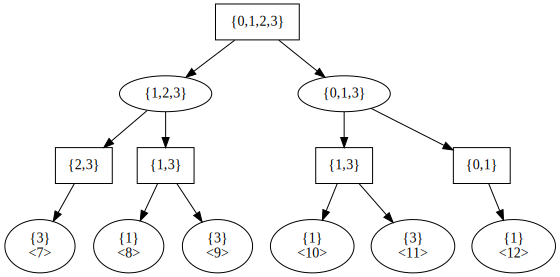

In [2]:
c = spot.acc_cond('Fin(0)&Inf(1)&(Inf(2)|Fin(3)) | (Inf(0)|Fin(1))&Fin(2)&Inf(3)')
t = spot.zielonka_tree(c)
t

Above we can see that `{0,1,2,3}` is a rejecting root, but it has two accepting maximal subsets: `{1,2,3}` and `{0,1,3}`.  Similarly, `{1,2,3}` has two rejecting maximal subsets: `{2,3}` and `{1,3}`.

The leaves of this tree have some additional numbers in angle brackets: those are the node numbers.  Each node has a number (it can be seen by hovering over it with the mouse), but those leaf numbers play a particular role when the tree is used to paritize an automaton.

This tree is also layered: all nodes in each layers are alternatively rejecting and accepting.  Layers are numbered incrementally from 0 at the root.  In this example, leaves are in layer 3.  Since it is conventional to put the root at the top, we will say that a node is high in the tree when it has a small level.

In this example, odd levels are accepting: we say the tree is odd.  On another example, it could be the other way around.  The `is_even()` method tells us which way it is.

In [3]:
t.is_even()

False

The number of leaves, and the number of the left-most leaf can be found with the following functions:

In [4]:
t.num_branches(), t.first_branch()

(6, 7)

The `step()` methods takes one leaf L, one set of colors S, and returns a pair: (leaf, level).
It works as follows: starting from node L, it walks up the tree until it has seen all colors in S, and then return the left-most leaf of the *next* branch of the node it has seen (assuming branches are ordered circularly from left to right).  The level returned is that of the highest node seen.

We refer to the process performed by `step(L,S)` as *reading S from L*. 

For instance reading `[3]` from 7 does not change the leaf, since that leaf is already labeled by `{3}`.  The level emitted is 3, since that's the level of 7.

In [5]:
t.step(7, [3])

(7, 3)

Reading `[3]` from 8, would however move to leave 9 and emit level 2.  Indeed, color 3 is not recognized by 8, so we move up to node 4 (the one labelled by `{1,3}`), emit its level (2), and go down to the left-most leaf of the next branch.

In [6]:
t.step(8, [3])

(9, 2)

If we read `[0,2]` from 9, we will have to go all the way up to the root (emitting 0) and then down to leaf 10:

In [7]:
t.step(9, [0,2])

(10, 0)

Now, let's take this a *step* further, and chain multiple steps, by reading a sequence of Sᵢ and producing a sequence of levels.

In [8]:
def steps(tree, leaf, seq_of_s):
    seq_of_lvl = []
    for s in seq_of_s:
        leaf, lvl = tree.step(leaf, s)
        seq_of_lvl.append(lvl)
    return leaf, seq_of_lvl

In [9]:
print(steps(t, 7, [[1],[0],[3],[1],[0],[3],[1],[0],[3],[1],[0],[3]]))
print(steps(t, 7, [[1],[3],[1],[3],[1],[3],[1],[3]]))

(10, [1, 0, 2, 2, 1, 1, 3, 1, 1, 3, 1, 1])
(9, [1, 2, 2, 2, 2, 2, 2, 2])


If we imagine an run looping on tree transitions labeled by `[1]`, `[0]`, `[3]`, we know (from the original acceptance condition) that it should be accepting.  Infinite repetition of the `step()` procedure will emit many levels, but the smallest level we see infinitely often is `1`. It corresponds to node 2, labeled by `{0,1,3}`: this is the highest node we visit infinitely often while stepping through this tree in a loop.

Similarly, a loop of two transitions labeled by `[1]` and `[3]` should be rejecting.  Stepping through the tree will emit infinitely many 2, a rejecting level.

All of this can be used to transform an automaton with arbitrary acceptance into a parity automaton, where the emitted levels will correspond to the priorities of the parity automaton.

The states of the new automaton will be pairs of states of the form `(original state, leaf)`. If the input edge `(src,dst)` has colors `S`, then the output edge `((src,leaf),(dst,nextleaf))` will have priority `L` where `L` and `nextleaf` are computed as `(nextleaf,L)=t.step(leaf, S)`.  The leaf used for the initial state does not really matter, we use the left-most one.

Let's create a random automaton with this example acceptance condition, and paritize it:

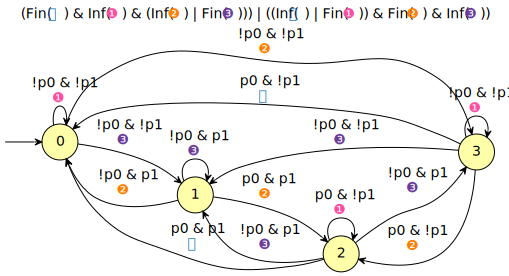

In [10]:
a1 = spot.automaton(f"randaut -Q4 --colored -e.7 -A '{c.get_acceptance()}' 2 |")
a1

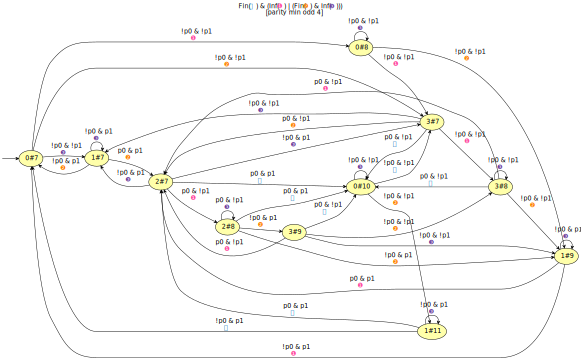

In [11]:
p1 = spot.zielonka_tree_transform(a1)
p1.copy_state_names_from(a1)
p1

Here the parity automaton output has as many priorities as there are levels in the Zielonka tree.

The call to `copy_state_names_from()` above causes the states to be labeled by strings of the form `orig#leaf` when `orig` is the original state number, and `leaf` is a leaf of the Zielonka tree.

Since this notebook is part of our test-suite, let us also make sure those automata are equivalent. 

In [12]:
spot.are_equivalent(p1, a1)

True

Note that `a1` above was generated as a so-called "colored" automaton, i.e., each edge has exactly one color.  But the transformation also works when edges have arbitrary and possibly empty subsets of colors.   In that case, reading a transition without color may emit a level that is not in the Zielonka tree, as if an additional imaginary layer labeled with the empty set was below the tree: we do not store this level for simplicity, but the `step()` function is aware of that.

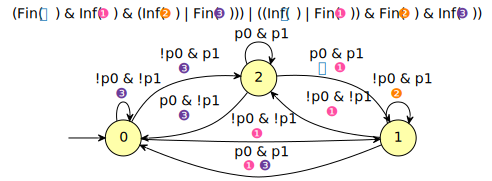

In [13]:
a2 = spot.automaton(f"randaut -Q3 -e.8 --seed=4 -A '{c.get_acceptance()}' 2 |")
a2

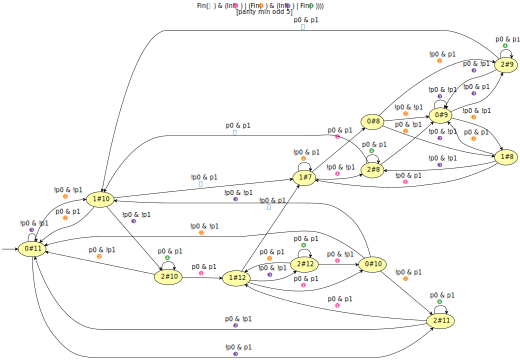

In [14]:
p2 = spot.zielonka_tree_transform(a2)
p2.copy_state_names_from(a2)
p2

The shape of the Zielonka tree (and later of the ACD), can also tell us if the acceptance condition can be converted into Rabin/Streett/parity without changing the automaton structure.  This follows from the following properties:

- an automaton is Rabin-type iff the union of any two accepting cycle is necessarily accepting
- an automaton is Streett-type iff the union of two rejecting cycle is necessarily rejecting
- an automaton is parity-type iff it is Rabin-type and Streett-type

Here, X-type means that the acceptance condition of the automaton can be changed into X without changing the transition structure (just by coloring it differently).  The Zielonka tree does not really look at the automaton, however its shape can still implies some typeness:

- an automaton is Rabin-type if (not iff) accepting nodes of the Zielonka tree have at most one child
- an automaton is Street-type if (not iff) rejecting nodes of the Zielonka tree have at most one child

The following methods provide this information:

In [15]:
t.has_rabin_shape(), t.has_streett_shape(), t.has_parity_shape()

(False, False, False)

Let's look at some examples:

(Fin(0) & Inf(1)) | (Fin(2) & Inf(3)) | (Fin(4) & Inf(5)) : True False False


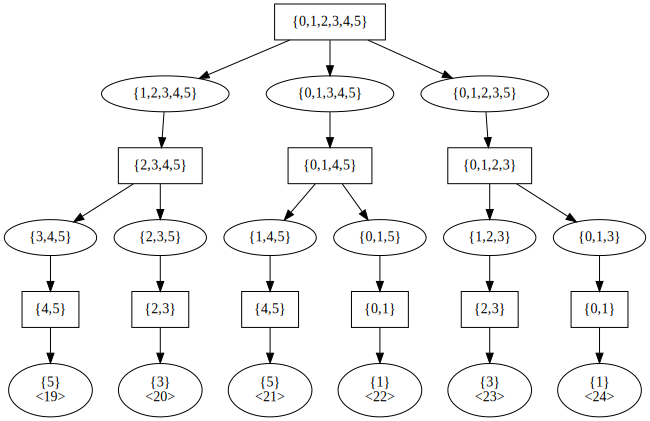

(Fin(0) | Inf(1)) & (Fin(2) | Inf(3)) & (Fin(4) | Inf(5)) : False True False


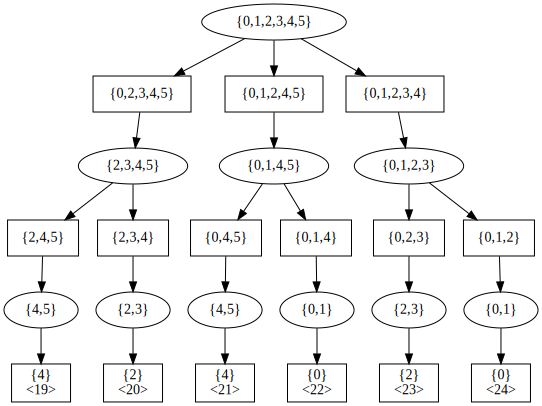

Fin(0) & (Inf(1) | (Fin(2) & (Inf(3) | Fin(4)))) : True True True


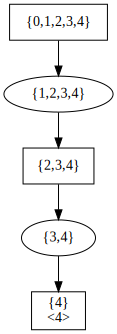

(Inf(0) & Fin(1)) | (Inf(2) & Fin(3) & Fin(4)) : True False False


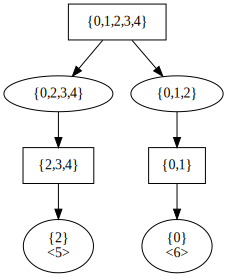

f : True True True


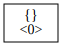

t : True True True


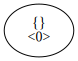

In [16]:
for ct in ('Rabin 3', 'Streett 3', 'parity min odd 5', 
           'Inf(0)&Fin(1) | (Inf(2)&Fin(3)&Fin(4))', 'f', 't'):
    cond = spot.acc_cond(ct)
    tcond = spot.zielonka_tree(cond)
    print(cond.get_acceptance(), ":", tcond.has_rabin_shape(), 
          tcond.has_streett_shape(), tcond.has_parity_shape());
    display(tcond)

## `zielonka_tree_options`

The `zielonka_tree` class accepts a few options that can alter its behaviour.

Options `CHECK_RABIN`, `CHECK_STREETT`, `CHECK_PARITY` can be combined with
`ABORT_WRONG_SHAPE` to abort the construction as soon as it is detected that the Zielonka tree has the wrong shape.  When this happens, the number of branches of the tree is set to 0.

For instance we can check that the original acceptance condition does not behaves like a Parity condition.

In [17]:
print(c)
z = spot.zielonka_tree(c, spot.zielonka_tree_options_ABORT_WRONG_SHAPE 
                          | spot.zielonka_tree_options_CHECK_PARITY)
print(z.num_branches())

(4, (Fin(0) & Inf(1) & (Inf(2) | Fin(3))) | ((Inf(0) | Fin(1)) & Fin(2) & Inf(3)))
0


Option `MERGE_SUBTREE` will fuse identical nodes, turning the tree into a DAG.  (Actually, because this tree is stored as a left-child right-sibling tree, only the children of identical nodes are merged.):

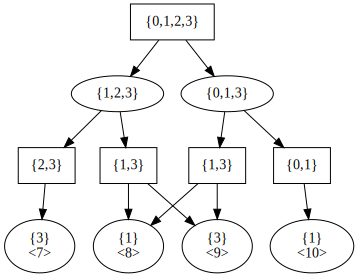

In [18]:
spot.zielonka_tree(c, spot.zielonka_tree_options_MERGE_SUBTREES)

Such a DAG cannot be used by `zielonka_tree_transform()`, but it saves memory if we are only checking the shape of the tree/DAG.

# Alternating Cycle Decomposition

We now turn to the ACD, which extends the Zielonka tree to take the automaton structure into account.  Instead of storing subsets of colors, it stores SCCs (not necessarily maximal).  In Spot, those SCCs are stored as bitvectors of edges.  The principle is similar: instead of one tree, we are building a forest, with one root per non-trivial maximal SCC.  The root of each tree is labeled by all the transitions in this maximal SCC: if such a huge cycle is accepting the node is said accepting and drawn as an ellipse, otherwise it is rejecting and drawn as a rectangle.  For children, we look for maximal subsets of cycles that can be rejecting (if the parent was accepting), or accepting (if the parent was rejecting).  

In other words all nodes correspond to SCCs that may not be maximal from a graph point of view, but that are maximal with respect to their accepting or rejecting status: adding more cycles to it would change that status.

In [19]:
a3 = spot.automaton("""HOA: v1 name: "(FGp0 & ((XFp0 & F!p1) | F(Gp1 &
XG!p0))) | G(F!p0 &\n(XFp0 | F!p1) & F(Gp1 | G!p0))" States: 10 Start:
0 AP: 2 "p0" "p1" Acceptance: 6 (Fin(0) & Fin(1)) | ((Fin(4)|Fin(5)) &
(Inf(2)&Inf(3))) properties: trans-labels explicit-labels trans-acc
complete properties: deterministic --BODY-- State: 0 [!0&!1] 0 {0 1 2
3 5} [!0&1] 1 [0&!1] 2 [0&1] 3 State: 1 [!0&1] 1 {1 3} [0&!1] 2
[!0&!1] 4 {0 1 2 3 5} [0&1] 5 State: 2 [!0&!1] 2 {1 2 3 5} [0&!1] 2 {2
4 5} [!0&1] 3 {1 3} [0&1] 3 {4} State: 3 [0&!1] 2 {2 4 5} [!0&1] 3 {1
3} [0&1] 5 {2 4} [!0&!1] 6 {1 2 3 5} State: 4 [!0&1] 1 {1 3} [0&!1] 2
[0&1] 3 [!0&!1] 7 State: 5 [0&!1] 2 {2 4 5} [0&1] 3 {4} [!0&1] 5 {1 3}
[!0&!1] 8 {1 3 5} State: 6 [0&!1] 2 {2 4 5} [!0&1] 3 {1 3} [0&1] 3 {4}
[!0&!1] 8 {1 3 5} State: 7 [0&!1] 2 [0&1] 5 [!0&!1] 7 {0 1 2 3 5}
[!0&1] 9 {1 2 3} State: 8 [0&!1] 2 {2 4 5} [!0&1] 5 {1 2 3} [0&1] 5 {2
4} [!0&!1] 8 {1 2 3 5} State: 9 [0&!1] 2 [0&1] 3 [!0&!1] 7 {0 1 3 5}
[!0&1] 9 {1 3} --END--""")

Here is the ACD for automaton `a3`, displayed below a copy of the automaton.  Note that the automaton and ACD are linked interactively: you may click on nodes of the ACD to highlight the cycles it stores, and you may click on a state or an edge in the automaton to highlight to relevant ACD nodes (it is easier to click on edge labels than on edges).

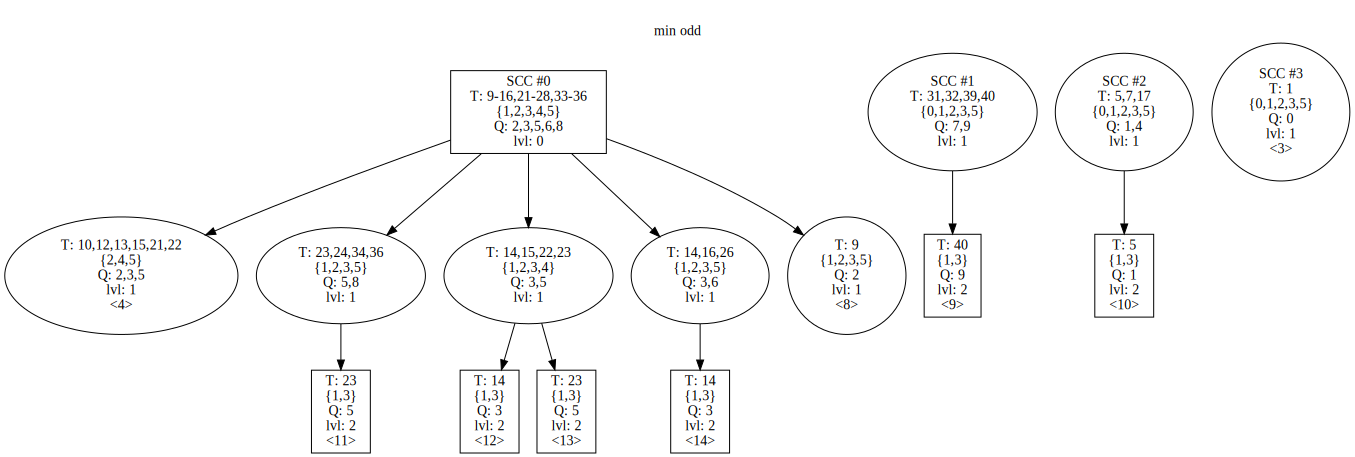

In [20]:
theacd = spot.acd(a3); theacd

The nodes of the ACD represent various bits of informations.  First, the root of each tree shows the number of the maximal SCC (as computed by `spot.scc_info`).  Trivial maximal SCCs (without cycles) are omitted from the construction.  Children are sorted by decreasing size of the SCCs they represent (i.e., decreasing count of edges).

The numbers after `T:` list the edges that belong to the strongly connected component.  The numbers are simply the indices of those edges in the automaton.  Between braces are the colors covered by all those edges, to decide if a cycle formed by all these edges would be accepting.  The numbers after `Q:` are the states touched by those edges.  `lvl:` indicates the level of each node.  Since some trees can have accepting roots while others have rejecting roots, the levels of some tree have been shifted down (i.e., the root start at levl 1 instead of 0) to ensure that all trees use the same parity.  The parity of the decomposition (i.e., whether even levels are accepting) is indicated by the `is_even()` method.

In [21]:
theacd.is_even()

False

Finally, the leaves have their node number indicated between angle brackets, but again, node numbers can be obtained by hovering over the node with the mouse.  This construction may step in more that just those indicated leaves because it will consider subtrees of the ACD.

For each state of the original automaton, there exists a subtree in the ACD formed by all the node whose `Q:` contain that state.  In the display of `theacd` above, you can click on any state of the input automaton to highlight the corresponding subtree of the ACD.

The `step()` method works similarly to Zielonka trees, except it uses edge number instead of colors.  It is given a node of the ACD and the number of an edge whose source state touched belong to `Q:` in the current node.  Then it walks up the tree until it finds a node that contains the given edge, emit the level of that node, and returns the left-most node of the next-branch in the sub-tree associated to the destination state.

For instance, let's consider the edges 2->3 and 3->2 in `a1`.  There are actually two edges going from 2 to 3.  Hovering above those arrows tells us the number of these edges:
  - 2->3 with {1,3} is edge 11
  - 2->3 with {4} is edge 12
  - 3->2 with {2,4,5} is edge 13
  
Let us assume we are in node 4 of the ACD (a node that contains state 2) and want to step through edges 12 and 13:

In [22]:
theacd.step(4, 12)

(4, 1)

In [23]:
theacd.step(4, 13)

(4, 1)

In both case, we stay in node 4 and emit level 1, this is the level of node 4, which contains both edges.

If we were to iterate through edges 11 and 13 instead, the story would be different:

In [24]:
theacd.step(4, 11)

(12, 0)

In [25]:
theacd.step(12, 13)

(8, 0)

In [26]:
theacd.step(8, 11)

(4, 0)

In [27]:
theacd.step(4, 13)

(4, 1)

And then it would loop again. 

Let's consider the first step.  Node 4 does not contains edge 11, so we move up the tree until we find node 0 that contains it, and emit level 0.  Then the destination of edge 11 is 3, so we consider the subtree associated to 3 (clicking on state 3 shows us this is the tree that has nodes 4,7,13 as leaves) and return the left-most node of the next branch: 12.

When we read edge 13 from node 12, go all the way up to node 0 again, and consider the left-most node of the next branch in the tree for the destination 2: that's node 8.  

Reading edges 11 and 13 will get us back to node 4. If we repeat this infinitely often, the smallest level we will see infinitely often is therefore 0, meaning that is a rejecting cycle.

The initial node we use to start this process can be any node that contains this state.  The `first_branch(s)` method returns the left-most node containing state `s`.

In [28]:
theacd.first_branch(2)

4

This `first_branch()` method is actually being used when `step()` is used to take an edge between two SCCs.  In that case the edge does not appear in the ACD, and `step()` will return the `first_branch()` for its destination, and level 0.

An automaton can be paritized using ACD following a procedure similar to Zielonka tree, with this more complex stepping process.

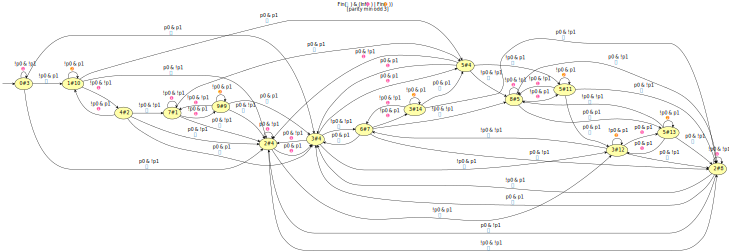

In [29]:
p3 = spot.acd_transform(a3, True)
p3.copy_state_names_from(a3)
p3

Note how the cycles `2#4 → 3#4 → 2#4` and `2#4 → 3#12 → 2#8 → 3#4 → 2#4` corresponds to the two cycles stepped though before.

In [30]:
a3.equivalent_to(p3)

True

By default, the construction will try to save colors by not emitting colors between SCCs, and not emitting colors for the largest level of an SCC when the parity allows it.  So this automaton can actually be paritized with two colors:

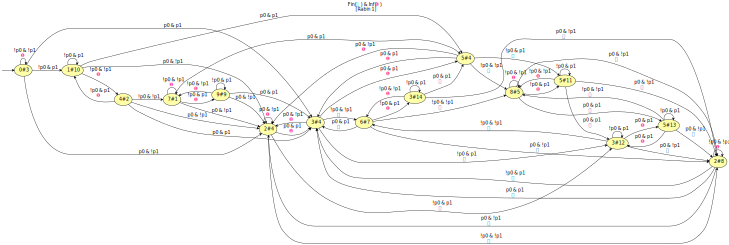

In [31]:
p3 = spot.acd_transform(a3)  # second argument defaults to False
p3.copy_state_names_from(a3)
assert a3.equivalent_to(p3)
p3


This transformation can have substantially fewer states than the one based on Zielonka tree, because the branches are actually restricted to only those that matter for a given state.

In [32]:
p3.num_states()

15

In [33]:
spot.zielonka_tree_transform(a3).num_states()

27

## Typeness checks

The ACD can be used to decide Rabin, Streett, and parity-typeness.  Testing Rabin-typeness requires making sure that round nodes have no children sharing a common state, and testing Streett-typeness needs a similar test for square node.  These additional tests have a cost, so they need to be enabled by passing `spot.acd_options_CHECK_RABIN`, `spot.acd_options_CHECK_STREETT`, or `spot.acd_options_CHECK_PARTIY` to the ACD constructor.  The latter option implies the former two.

As an example, automaton `a3` is Rabin-type because nodes 12 and 13, which are the children of the only round node with more than one child, do not share any state.  It it not Street-type, because for instance state 2 appears in both nodes 4 and 8, two children of a square node.

In [34]:
theacd = spot.acd(a3, spot.acd_options_CHECK_PARITY)

In [35]:
print(theacd.has_rabin_shape(), theacd.has_streett_shape(), theacd.has_parity_shape())

True False False


Calling the above methods without passing the relevant option will raise an exception.

Additionally, when the goal is only to check some typeness, the construction of the ACD can be aborted as soon as the typeness is found to be wrong.  This can be enabled by passing the additional option `spot.acd_options_ABORT_WRONG_SHAPE`.  In case the construction is aborted the ACD forest will be erased (to make sure it is not used), and `node_count()` will return 0.

In [36]:
print(theacd.node_count())

15


In [37]:
theacd = spot.acd(a3, spot.acd_options_CHECK_STREETT | spot.acd_options_ABORT_WRONG_SHAPE)

In [38]:
print(theacd.has_streett_shape(), theacd.node_count())

False 0


## State-based transformation

The ACD usage can be modified slightly in order to produce a state-based automaton.  The rules for stepping through the ACD are similar, except that when we detect that a cycle through all children of a node has been done, we return the current node without going to the leftmost leave of the next children.  When stepping a transition from a node a child, we should act as if we were in the leftmost child of that node containing the source of that transition.  Stepping through a transition this way do not emit any color, instead the color of a state will be the level of its associated node.
(This modified transformation do not claim to be optimal, unlike the transition-based version.)

The `ORDER_HEURISTIC` used below will be explained in the next section, it just alters ordering of children of the ACD in a way that the state-based transformation prefers.

In [39]:
theacd = spot.acd(a3, spot.acd_options_ORDER_HEURISTIC)

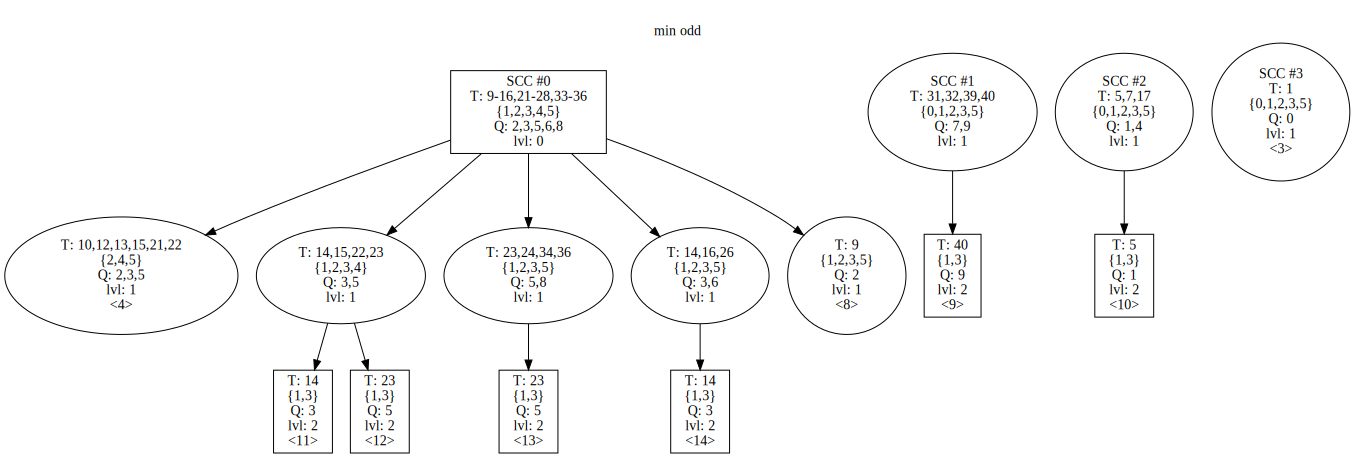

In [40]:
theacd

Let set what happens when we step through the two self-loops of state 2 (edges 9 and 10).

In [41]:
theacd.first_branch(2)

4

In [42]:
theacd.state_step(4, 9)

8

In [43]:
theacd.state_step(8, 10)

0

In [44]:
# since 0 is not a leaf of the tree associated to state 2, the following acts like state_step(first_branch(2), 9)
theacd.state_step(0, 9) 

8

The state-based version of the ACD transformation is `acd_transform_sbacc()`.  In the output, the cycle between `2#8` and `2#0` corresponds to the repetitions of edges 9 and 10 we stepped through above.

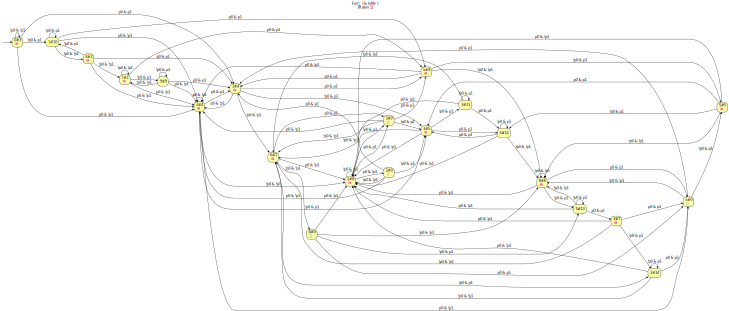

In [45]:
s3 = spot.acd_transform_sbacc(a3);
assert s3.equivalent_to(a3)
s3.copy_state_names_from(a3)
s3

In this case, the number of states we obtain with `acd_transform_sbacc()` is smaller than what we would obtain by calling `sbacc()` on the result of `acd_transform()`.

In [46]:
print(s3.num_states(), 
      spot.sbacc(spot.acd_transform(a3)).num_states())

22 28


## An ordering heuristic for state-based transformation

We now explain the `ORDER_HEURISTIC` option, by first looking at an example without it.

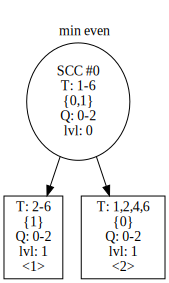

In [47]:
a4 = spot.automaton("""HOA: v1 States: 3 Start: 
0 AP: 1 "p" acc-name: generalized-Buchi 2 Acceptance: 
2 Inf(1)&Inf(0) properties: trans-labels implicit-labels 
trans-acc complete deterministic --BODY-- State: 0 0 {0}
1 State: 1 1 {1} 2 State: 2 2 {1} 0 --END--""")
spot.acd(a4)

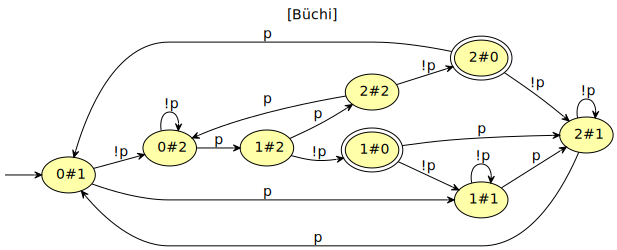

In [48]:
s4 = spot.acd_transform_sbacc(a4, False, False) # The third argument disables the heuristic
s4.copy_state_names_from(a4)
s4

One this example, we can see that whenever an edge leaves not 2, it creates a copy of the target state.

The `ORDER_HEURISTIC` option of the ACD construction, attempts to order the children of a node by decreasing number of number of successors that are out of the node.  It is activated by default inside `spot.acd_transform_sbacc()`.

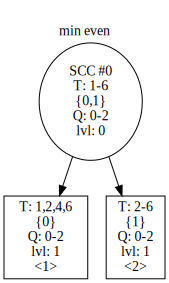

In [49]:
spot.acd(a4, spot.acd_options_ORDER_HEURISTIC)

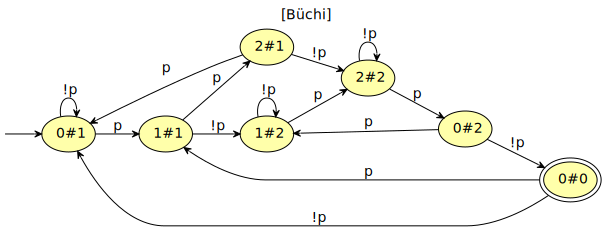

In [50]:
s4b = spot.acd_transform_sbacc(a4)
s4b.copy_state_names_from(a4)
s4b

# More examples

These additional examples also contribute to our test suite.

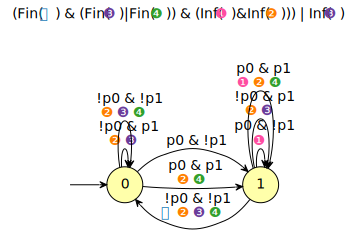

In [51]:
c = spot.automaton("""
HOA: v1
States: 2
Start: 0
AP: 2 "p1" "p0"
Acceptance: 5 (Fin(0) & (Fin(3)|Fin(4)) & (Inf(1)&Inf(2))) | Inf(3)
properties: trans-labels explicit-labels trans-acc complete
properties: deterministic stutter-invariant
--BODY--
State: 0
[0&!1] 0 {2 3}
[!0&!1] 0 {2 3 4}
[!0&1] 1
[0&1] 1 {2 4}
State: 1
[!0&!1] 0 {0 2 3 4}
[!0&1] 1 {1}
[0&!1] 1 {2 3}
[0&1] 1 {1 2 4}
--END--
"""); c

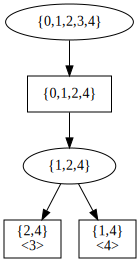

In [52]:
spot.zielonka_tree(c.acc())

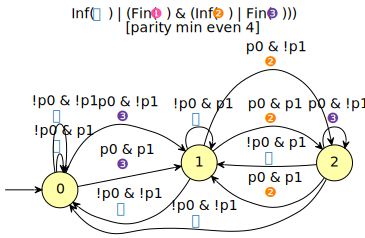

In [53]:
d = spot.zielonka_tree_transform(c); d

In [54]:
assert c.equivalent_to(d)

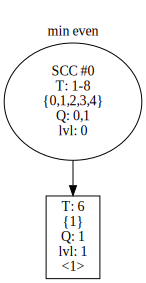

In [55]:
cacd = spot.acd(c); cacd

In [56]:
cacd.state_step(1, 7)

0

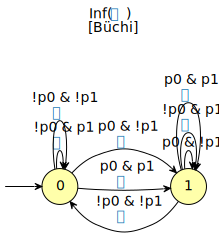

In [57]:
d = spot.acd_transform(c); d

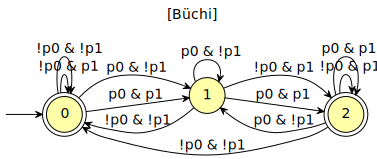

In [58]:
e = spot.acd_transform_sbacc(c); e

In [59]:
assert c.equivalent_to(d)
assert c.equivalent_to(e)

Paritizing a generalized-Büchi automaton with `acd_transform()` produces a Büchi automaton.
The Zielonka-tree transformation produces a larger automaton because it ignores the transition structure, and also it uses an extra and unnecessary color (because it was not taught how to omit it).

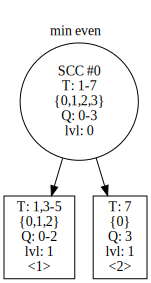

In [60]:
g = spot.automaton("""HOA: v1 States: 4 Start: 0 AP: 2 "p0" "p1"
acc-name: generalized-Buchi 4 Acceptance: 4
Inf(0)&Inf(1)&Inf(2)&Inf(3) properties: trans-labels explicit-labels
trans-acc --BODY-- State: 0 [!0&1] 2 {0 1 2} [!0&!1] 3 {0 1 2 3}
State: 1 [!0&1] 0 {0 1 2} [!0&!1] 2 {0} State: 2 [!0&1] 1 {0} State: 3
[!0&!1] 2 {0 1 2 3} [0&!1] 3 {0} --END--""")

spot.acd(g)

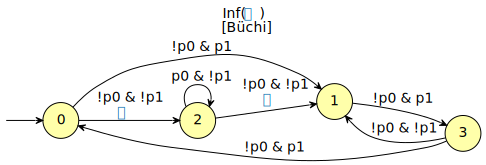

In [61]:
spot.acd_transform(g)

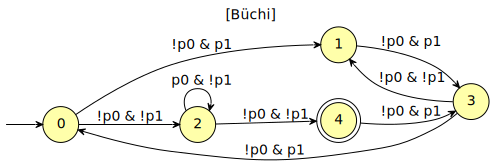

In [62]:
spot.acd_transform_sbacc(g)

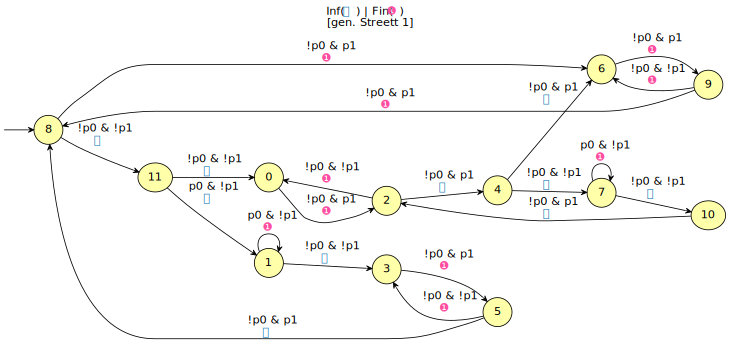

In [63]:
spot.zielonka_tree_transform(g)

An issue in Spot is to always ensure that property bits of automata (claiming that an automaton is weak, inherently weak, deterministic, etc.) are properly preserved or reset.

Here if the input is inherently weak, the output should be weak. 

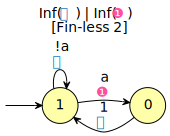

In [64]:
w = spot.automaton("""HOA: v1
States: 2
Start: 1
AP: 1 "a"
Acceptance: 2 Inf(0) | Inf(1)
properties: trans-labels explicit-labels trans-acc colored complete
properties: deterministic inherently-weak
--BODY--
State: 0
[t] 1 {0}
State: 1
[0] 0 {1}
[!0] 1 {0}
--END--"""); w

In [65]:
w.prop_weak(), w.prop_inherently_weak()

(spot.trival_maybe(), spot.trival(True))

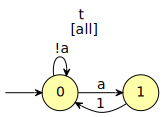

In [66]:
w2 = spot.acd_transform(w); w2

In [67]:
w2.prop_weak(), w2.prop_inherently_weak()

(spot.trival(True), spot.trival(True))